# Olimpic games analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/BI/Statistics/athlete_events.zip" -d "./athlete_events"

Archive:  /content/drive/MyDrive/BI/Statistics/athlete_events.zip
  inflating: ./athlete_events/athlete_events00.csv  
  inflating: ./athlete_events/athlete_events01.csv  
  inflating: ./athlete_events/athlete_events02.csv  
  inflating: ./athlete_events/athlete_events03.csv  
  inflating: ./athlete_events/athlete_events04.csv  
  inflating: ./athlete_events/athlete_events05.csv  
  inflating: ./athlete_events/athlete_events06.csv  
  inflating: ./athlete_events/athlete_events07.csv  
  inflating: ./athlete_events/athlete_events08.csv  
  inflating: ./athlete_events/athlete_events09.csv  
  inflating: ./athlete_events/athlete_events10.csv  
  inflating: ./athlete_events/athlete_events11.csv  


## 1. Loading the given datasets

In [5]:
def read_data(path_to_folder, extension = ".csv"):
    df = pd.DataFrame()
    for x in os.listdir(path_to_folder):
        # if the file has the proper extension we add it to the df
        if x.endswith(extension):
            df_temp = pd.read_csv(path_to_folder+x) # read_csv function could read not only csv
            df = pd.concat([df, df_temp])
    return df

In [85]:
path = "./athlete_events/"
df = read_data(path)

In [86]:
df.head(3)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,124517,William Van Dijck,M,23.0,185.0,65.0,Belgium,BEL,1984 Summer,1984.0,Summer,Los Angeles,Athletics,"Athletics Men's 3,000 metres Steeplechase",NaN
1,124517,William Van Dijck,M,27.0,185.0,65.0,Belgium,BEL,1988 Summer,1988.0,Summer,Seoul,Athletics,"Athletics Men's 3,000 metres Steeplechase",NaN
2,124517,William Van Dijck,M,31.0,185.0,65.0,Belgium,BEL,1992 Summer,1992.0,Summer,Barcelona,Athletics,"Athletics Men's 3,000 metres Steeplechase",NaN


In [ ]:
df.shape

(271115, 15)

## 2. Data exploration - is the data correct?

We can check if there are any missing values in the dataframe:

In [ ]:
df.dtypes

ID          int64
Name       object
Sex        object
Age       float64
Height    float64
Weight    float64
Team       object
NOC        object
Games      object
Year      float64
Season     object
City       object
Sport      object
Event      object
Medal      object
dtype: object

In [ ]:
df.isna().sum()

ID             0
Name           1
Sex            2
Age         9476
Height     60172
Weight     62876
Team           3
NOC            4
Games          5
Year           7
Season         7
City           7
Sport          7
Event          8
Medal     231333
dtype: int64

There are just few values missing in the columns except Age, Height, Weight and Medal, so we can just drop these rows without any serious consequences:

In [87]:
cols = set(df.columns).difference({"Age", "Height", "Weight", "Medal"})
df.dropna(subset=list(cols), inplace = True)

It is predictable that there are many participans without medals - we can just substitute NaNs by zero:

In [ ]:
df["Medal"].unique()

array([nan, 'Gold', 'Bronze', 'Silver'], dtype=object)

In [88]:
df["Medal"].fillna(value="No medals", inplace=True)

In [ ]:
df["Medal"].unique()

array([0, 1, 3, 2])

In [ ]:
df.isna().sum()

ID            0
Name          0
Sex           0
Age        9473
Height    60168
Weight    62872
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport         0
Event         0
Medal         0
dtype: int64

Apart from it we can see that there are many athlets records which are missing age, weight and height. To fill in these gaps we can use mean, mode, median or predict the number using the distribution of the rest of the values.

If we look at the numbers, there are $9473/271115 = 0.035 = 3.5\%$ for age, $60172/271115 = 0.22 = 22\%$ of heights and $62876/271115 = 0.23 = 23\%$ of weights are missing. This is a very big amount of data. So for age it is not a big loss and we can just fill the missing values with mean. However, for weight and height we can try to apply more complex approach to predict in the misssing data.

### Age

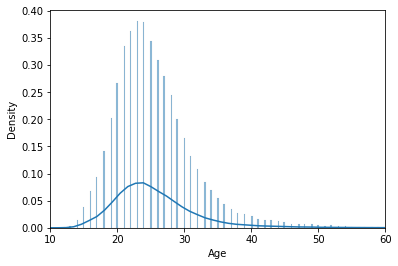

In [ ]:
fig, ax = plt.subplots()
sns.histplot(df["Age"], stat="density", kde=True)
ax.set_xlim(10, 60)
plt.show()

In [89]:
df["Age"] = df["Age"].fillna(value=df["Age"].mean())

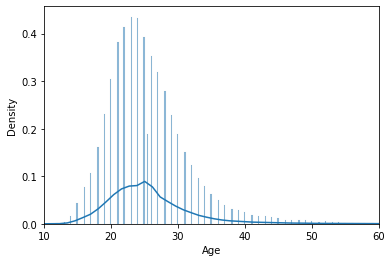

In [ ]:
fig, ax = plt.subplots()
sns.histplot(df["Age"], stat="density", kde=True)
ax.set_xlim(10, 60)
plt.show()

We can observe that the distribution became a bit more narrow but did not change dramatically.

### Height and Weight

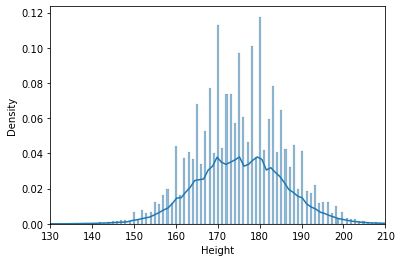

In [ ]:
fig, ax = plt.subplots()
sns.histplot(df["Height"], stat="density", kde=True)
ax.set_xlim(130, 210)
plt.show()

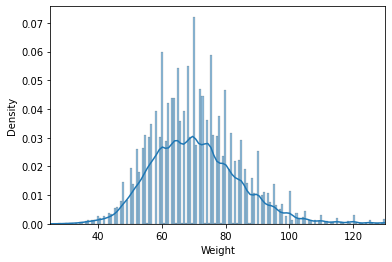

In [ ]:
fig, ax = plt.subplots()
sns.histplot(df["Weight"], stat="density", kde=True)
ax.set_xlim(25, 130)
plt.show()

To fill the data of these two columns we can use the k-Nearest Neighbors method, implemented in *sklearn* library as *KNNImputer*. This algorithm will fill in the missin value according to the values of its nearest neighbours in the data. We will use here the default parameters which are 5 neighbours and euclidean distance.

In order to use this method we have to use only numerical values, so we can select columns that somehow affect the hight and weight and decode each group using get dummies:

In [14]:
df_mod = df[["Sex", "Age", "Height", "Weight"]]
df_mod = pd.get_dummies(df_mod, columns = ["Sex"])
df_mod.head()

,Age,Height,Weight,Sex_F,Sex_G,Sex_M
0,23.0,185.0,65.0,0,0,1
1,27.0,185.0,65.0,0,0,1
2,31.0,185.0,65.0,0,0,1
3,21.0,NaN,NaN,0,0,1
4,35.0,176.0,66.0,1,0,0


In [15]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

df_mod_trf = imputer.fit_transform(df_mod)

In [11]:
df_mod_trf.head()

,Unnamed: 0,Age,Height,Weight,Sex_F,Sex_G,Sex_M
0,0,23.0,185.0,65.0,0.0,0.0,1.0
1,1,27.0,185.0,65.0,0.0,0.0,1.0
2,2,31.0,185.0,65.0,0.0,0.0,1.0
3,3,21.0,179.6,87.4,0.0,0.0,1.0
4,4,35.0,176.0,66.0,1.0,0.0,0.0


In [18]:
df_mod_trf = pd.DataFrame(df_mod_trf, columns=df_mod.columns)

In [21]:
df_mod_trf.isna().sum()

Age       0
Height    0
Weight    0
Sex_F     0
Sex_G     0
Sex_M     0
dtype: int64

Lets look on the distribution after prediction:

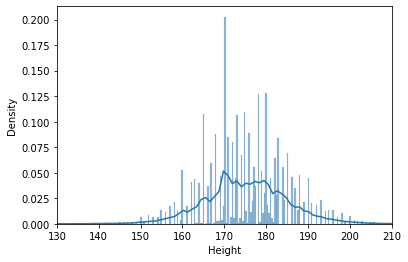

In [22]:
fig, ax = plt.subplots()
sns.histplot(df_mod_trf["Height"], stat="density", kde=True)
ax.set_xlim(130, 210)
plt.show()

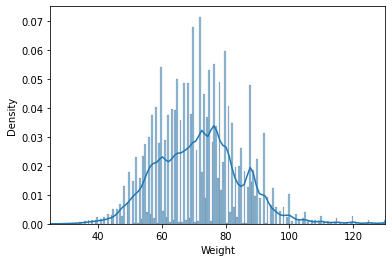

In [23]:
fig, ax = plt.subplots()
sns.histplot(df_mod_trf["Weight"], stat="density", kde=True)
ax.set_xlim(25, 130)
plt.show()

There are some fluctuations in frequencies we gerenally, new data fitted the distribution and did not shift it to any side.

In [91]:
df[["Height", "Weight"]] = df_mod_trf[["Height", "Weight"]]

In [95]:
# the prediction was quite long so I downloaded data just in case

df.to_csv('./df.csv')  

In [92]:
df.isna().sum()

ID        0
Name      0
Sex       0
Age       0
Height    0
Weight    0
Team      0
NOC       0
Games     0
Year      0
Season    0
City      0
Sport     0
Event     0
Medal     0
dtype: int64

## 3. The youngest athletes in 1992

In [30]:
fem_92 = df[df["Sex"] == "F"]
male_92 = df[df["Sex"] == "M"]
fem_92.sort_values(by=['Age'], inplace=True)
male_92.sort_values(by=['Age'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [33]:
fem_92.head(3)["Age"]

16912    11.0
11043    11.0
4764     11.0
Name: Age, dtype: float64

In [34]:
male_92.head(3)["Age"]

6996     10.0
5480     11.0
16380    12.0
Name: Age, dtype: float64

As we can see, the youngest athletes in the Olympics 1992 were only 10-12 years old!

## 4. Mean and std of height for each sex

In [35]:
df.groupby(by="Sex")["Height"].mean()

Sex
F    174.525789
G    179.000000
M    175.319600
Name: Height, dtype: float64

In [36]:
df.groupby(by="Sex")["Height"].std()

Sex
F    10.009300
G    14.142136
M     9.838239
Name: Height, dtype: float64

This is very interesting result, because usually we expect to see a big difference between height of men and women. 

## 5. Mean and std for the female tennis players in 2000

In [42]:
f_tennis = df[(df["Sex"] == "F") & (df["Sport"] == "Tennis") & (
    df["Year"] == 2000)]
print("The average hight of female tennis players in Olympics 2000 was ",
      round(f_tennis["Height"].mean(), 2))

The average hight of the female tennis player in Olympics 2000 was  175.97


In [43]:
print("The standart deviation for the hight of female tennis player in Olympics 2000 was ",
      round(f_tennis["Height"].std(), 2))

The standart deviation for the hight of female tennis player in Olympics 2000 was  10.78


## 6. The heaviest athlete on Olympics 2006

In [47]:
og_2006 = df[df["Year"] == 2006]
og_2006[og_2006["Weight"] == og_2006["Weight"].max()]["Sport"]

19545    Cross Country Skiing
Name: Sport, dtype: object

The heaviest athlete on Olympics 2006 was competing in cross country skiing.

## 7. Total number of medals for female athletes from 1980 to 2010

In [53]:
df[(df["Sex"] == "F") & (1979<df["Year"]) & (df["Year"]<2011) & (df["Medal"] != "No medals")].count()[0]

44044

The total number of female athletes for this period was 44044.

## 8. How many times John Aalberg participated in Olympics?

In [54]:
len(df[df["Name"] == "John Aalberg"]["Year"].unique())

2

This sportsman participated in the Olympics two times.

## 9. Age groups on Olympics 2008

In [57]:
og2008 = df[df["Year"] == 2008]

In [63]:
bins = [15, 24, 34, 44, 54]
pd.cut(og2008['Age'], bins=bins).value_counts()

(24, 34]    6369
(15, 24]    6217
(34, 44]     790
(44, 54]     116
Name: Age, dtype: int64

The majority of athletes on Olympics 2008 belong to the age group of 25-34 years, followed by the group of 15-24 year-olds.

In [66]:
og2008.reset_index(inplace=True)

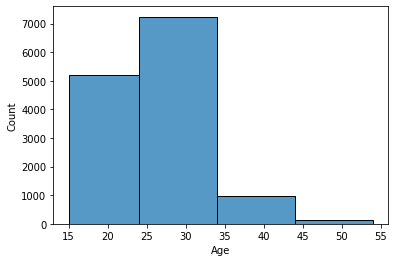

In [67]:
sns.histplot(data=og2008, x="Age", bins=bins)
plt.show()

## 10. Sports on Olympics 1994 and 2002

In [69]:
len(df[df["Year"] == 2002]["Sport"].unique()) - len(df[df["Year"] == 1994]["Sport"].unique())

3

Three new types of sport appeared on the Olympics 2002 comparing to Olympics 1994.

## 11. Top-3 countries on winter and summer Olympics

In [21]:
counts = df[['Medal', 'Season', 'NOC']].query('Medal != "No medals"').groupby(
    ['Season', "Medal"]).apply(
    lambda x: x.value_counts().head(3))

counts = counts.reset_index(level=[2, 3])[[0]].rename(columns={0: "Medals"})
counts

Medals
Season Medal  NOC        
Summer Bronze NED      46
              GER      23
              FRA      20
       Gold   NED      41
              USA      40
              URS      24
       Silver NED      54
              BEL      26
              USA      23
Winter Bronze NED      10
              ITA       5
              FIN       5
       Gold   URS      13
              NED       7
              RUS       5
       Silver NED       6
              RUS       6
              CAN       4

## 12. Z-score calculation for Hight column

In [22]:
def standardize(values):
    return (values - values.mean()) / values.std()


df["Height_z_scores"] = standardize(df.Height)

## 13. Min-Max scaling of Height

The Min-Max normalization could be perfoirmed using the following formula:   $x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$

This way of normalization gives the data in range from 0 to 1, where values equal to min become zero and values equal to max become 1. 

In [23]:
minh = df["Height"].min()
maxh = df["Height"].max()

def minmax(min, max, x):
    return (x-min)/(max-min)


df["Height_min_max_scaled"] = df["Height"].apply(lambda x:  minmax(minh, maxh, x))

In [24]:
df.head(3)

,Unnamed: 0,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Height_z_scores,Height_min_max_scaled
0,0,124517,William Van Dijck,M,23.0,185.0,65.0,Belgium,BEL,1984 Summer,1984.0,Summer,Los Angeles,Athletics,"Athletics Men's 3,000 metres Steeplechase",No medals,0.957491,0.567568
1,1,124517,William Van Dijck,M,27.0,185.0,65.0,Belgium,BEL,1988 Summer,1988.0,Summer,Seoul,Athletics,"Athletics Men's 3,000 metres Steeplechase",No medals,0.957491,0.567568
2,2,124517,William Van Dijck,M,31.0,185.0,65.0,Belgium,BEL,1992 Summer,1992.0,Summer,Barcelona,Athletics,"Athletics Men's 3,000 metres Steeplechase",No medals,0.957491,0.567568


## 14. Comparison of some parameters for athlets on winter Olympics

In [3]:
df = pd.read_csv("./df.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


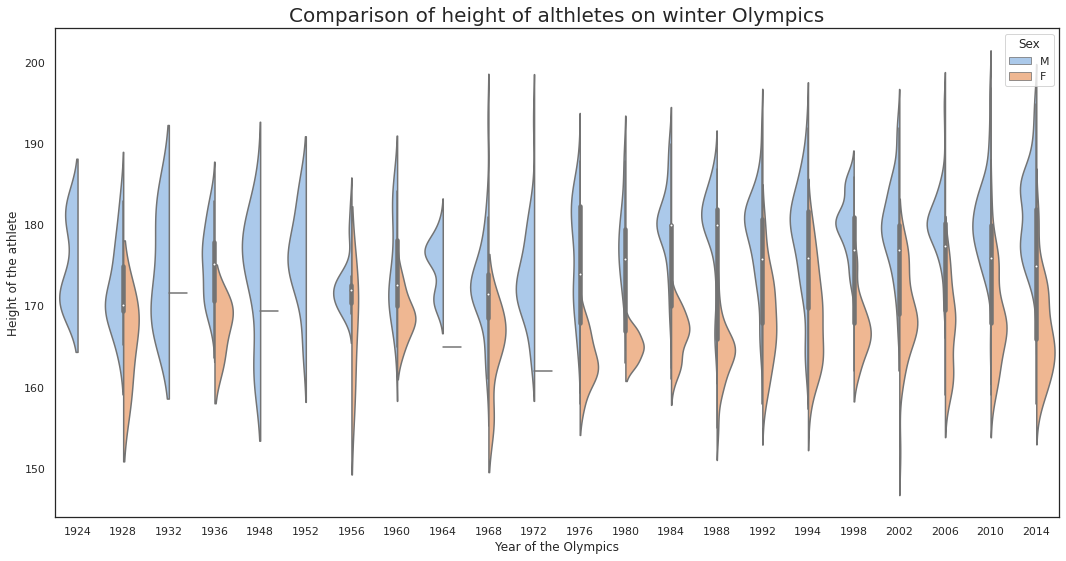

In [16]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(18, 9))

df_winter = df[df["Season"] == "Winter"]
df_winter["Year"] = df_winter["Year"].astype('int')

g = sns.violinplot(data=df_winter, y="Height", x="Year", hue="Sex",
               split=True, palette="pastel")

ax.set(ylabel="Height of the athlete", xlabel="Year of the Olympics")

g.axes.set_title("Comparison of height of althletes on winter Olympics", fontsize=20)

plt.show()

We can see that the female height is slightly shifting to the lower values, when the male values are growing and becoming more disperse. Gerenally, we can say, that the range of heights of the athletes became wider from the 1924 year. 

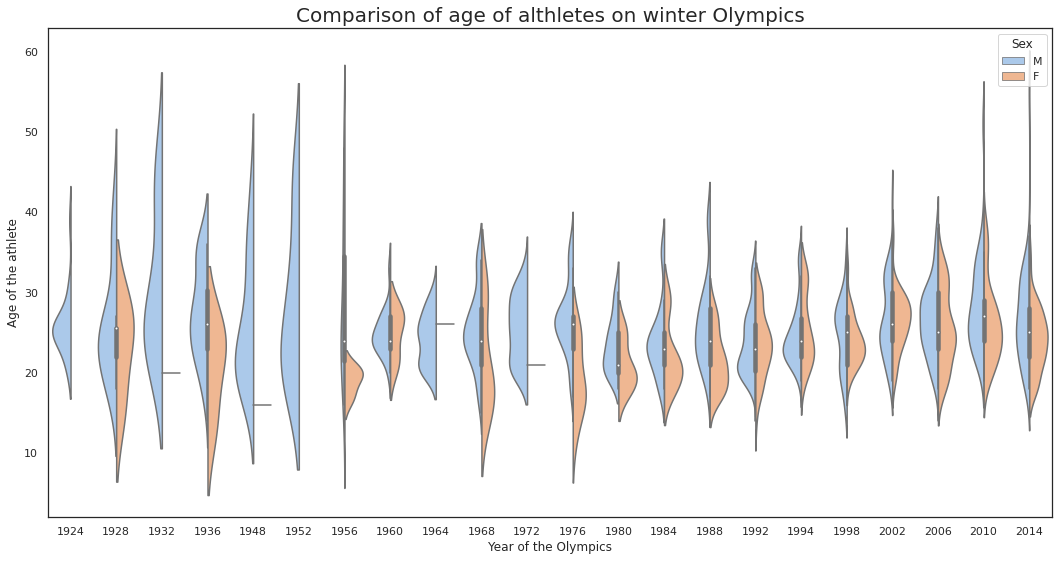

In [19]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(18, 9))

g = sns.violinplot(data=df_winter, y="Age", x="Year", hue="Sex",
               split=True, palette="pastel")

ax.set(ylabel="Age of the athlete", xlabel="Year of the Olympics")

g.axes.set_title("Comparison of age of althletes on winter Olympics", fontsize=20)

plt.show()

We can see that the age of athletes was quite wide at the beginning but then became thinner after the year of 1956. We can suppose that is was the consequence of the World War 2, so there are way less people of the 30+ years. 

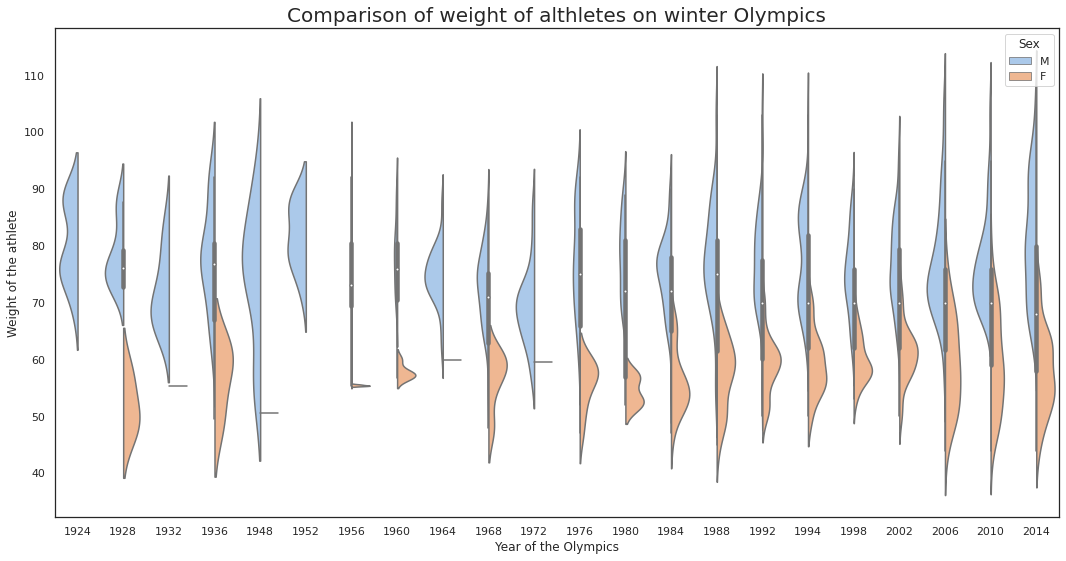

In [18]:
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(18, 9))


g = sns.violinplot(data=df_winter, y="Weight", x="Year", hue="Sex",
               split=True, palette="pastel")

ax.set(ylabel="Weight of the athlete", xlabel="Year of the Olympics")

g.axes.set_title("Comparison of weight of althletes on winter Olympics", fontsize=20)

plt.show()

The distributions of weight of male and female athletes in from 1924 to 1976 almost did not overlap. However with ages, we can observe the widening of the distributions and the bigger zone of the overlap. 

## 15. Team and Medal correlation

In [97]:
df.Team = pd.Categorical(df.Team)
df['Team_code'] = df.Team.cat.codes

medals_dict = {"No medals": 0, "Bronze": 1, "Silver": 2, "Gold": 3}

df['Medal_code'] = df.Medal.apply(lambda x: medals_dict[x])
df.Medal_code = pd.to_numeric(df.Medal_code)
df.head(2)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Team_code,Medal_code
0,124517,William Van Dijck,M,23.0,185.0,65.0,Belgium,BEL,1984 Summer,1984.0,Summer,Los Angeles,Athletics,"Athletics Men's 3,000 metres Steeplechase",No medals,96,0
1,124517,William Van Dijck,M,27.0,185.0,65.0,Belgium,BEL,1988 Summer,1988.0,Summer,Seoul,Athletics,"Athletics Men's 3,000 metres Steeplechase",No medals,96,0


In [24]:
df[["Team_code", "Medal_code"]].corr()

,Team_code,Medal_code
Team_code,1.00000,0.07084
Medal_code,0.07084,1.00000


We can see that there is a small positive correlation between these two parameters. We can construct linear regression model and look at the equation in the end:

In [102]:
reg = LinearRegression().fit(df[["Team_code"]], df["Medal_code"])

In [105]:
print(f"The equation is: medal = team*{reg.coef_[0]} + {reg.intercept_}")

The equation is: medal = team*0.00015899736019698126 + 0.201537572939725


So we can say that there is a small positive correlation between these two parameters. But before we were prediction type of the medal, let's try predicting total number of medals:

In [106]:
table = pd.crosstab(df["Team"], df["Medal"])
table["Total"] = table["Bronze"] + table["Silver"] + table["Gold"]
table.head()

Medal,Bronze,Gold,No medals,Silver,Total
Team,,,,,
30. Februar,0,0,2,0,0
A North American Team,4,0,0,0,4
Acipactli,0,0,3,0,0
Acturus,0,0,2,0,0
Afghanistan,2,0,124,0,2


In [107]:
d_medals = table.reset_index().rename_axis(columns = None)
d_medals.sort_values(by = "Total", ascending=False, inplace=True)
d_medals.head()

,Team,Bronze,Gold,No medals,Silver,Total
1095,United States,1233,2474,12628,1512,5219
976,Soviet Union,677,1058,3084,716,2451
398,Germany,678,679,7342,627,1984
412,Great Britain,572,519,9731,582,1673
361,France,577,455,10438,518,1550


In [111]:
d_medals["Team"] = d_medals["Team"].astype('object')
d_medals.Team = pd.Categorical(d_medals.Team)
d_medals['Team_code'] = d_medals.Team.cat.codes

In [112]:
d_medals[["Team_code", "Total"]].corr()

,Team_code,Total
Team_code,1.000000,0.018458
Total,0.018458,1.000000


Here we can also observe small positive correlation.

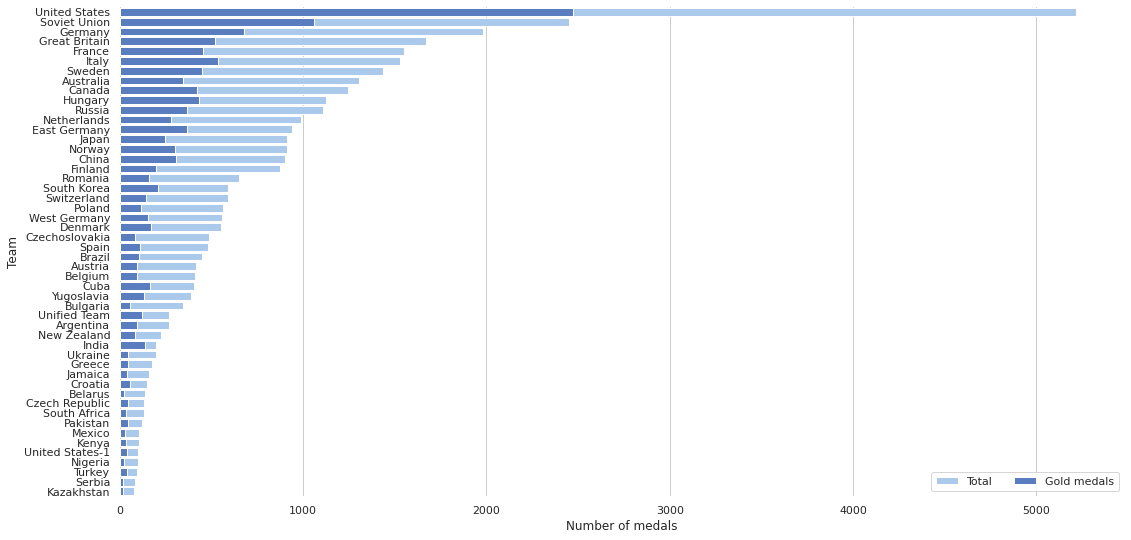

In [83]:
f, ax = plt.subplots(figsize=(18, 9))
sns.set_theme(style="whitegrid")


top_30 = d_medals.head(50)
top_30.reset_index(inplace=True, drop=True)

sns.set_color_codes("pastel")
sns.barplot(x=top_30["Total"], y=top_30["Team"], data=top_30, label="Total", color="b")

sns.set_color_codes("muted")
sns.barplot(x="Gold", y="Team", data=top_30, label="Gold medals", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlabel="Number of medals", ylabel="Team")
sns.despine(left=True, bottom=True)

plt.show()

We can observe that USA has few times more medals than other counties, and in general the countries from Bulgaria have significantly more medals than the rest of countries.